In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from src.models import get_model, SteganographyModels
from src.__main__ import CLI

print("Available models:")
print('\n'.join(list(map(lambda x: str(x).split('.')[-1], SteganographyModels))))

Available models:
LSB
BASE_MERGE


## Constants

In [66]:
#IMAGE_PATH = "../tests/test_images/cat.jpg"
IMAGE_PATH = "../tests/test_images/cs.png"

MODEL_NAME = "BASE_MERGE"

MESSAGE = "Hello world !" * 100
MESSAGE = "../tests/test_images/cat.jpg"

## Show image and hide the image

In [67]:
cli = CLI()

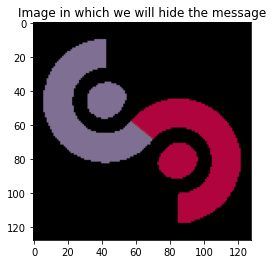

In [68]:
image = cli._load_image(IMAGE_PATH)
plt.figure()
plt.title("Image in which we will hide the message")
plt.imshow(image)
plt.show()

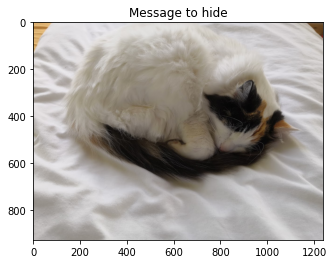

In [69]:
message = cli._load_message(MESSAGE)

if isinstance(message, str):
    print(message)
else:
    plt.figure()
    plt.title("Message to hide")
    plt.imshow(message)
    plt.show()

In [70]:
model = get_model(MODEL_NAME)

In [71]:
encoded_image = model.encode(
    image=image, message=message
)

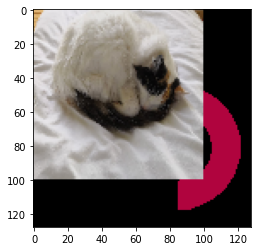

In [72]:
plt.figure()
plt.imshow(encoded_image)
plt.show()

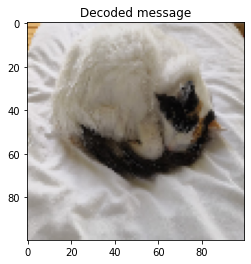

In [73]:
message = model.decode(encoded_image)
if isinstance(message, str):
    print('Decoded message:')
    print(message[:40])
    assert message == MESSAGE, "The messages are not the same"
else:
    plt.figure()
    plt.title("Decoded message")
    plt.imshow(message)
    plt.show()

## Data analysis

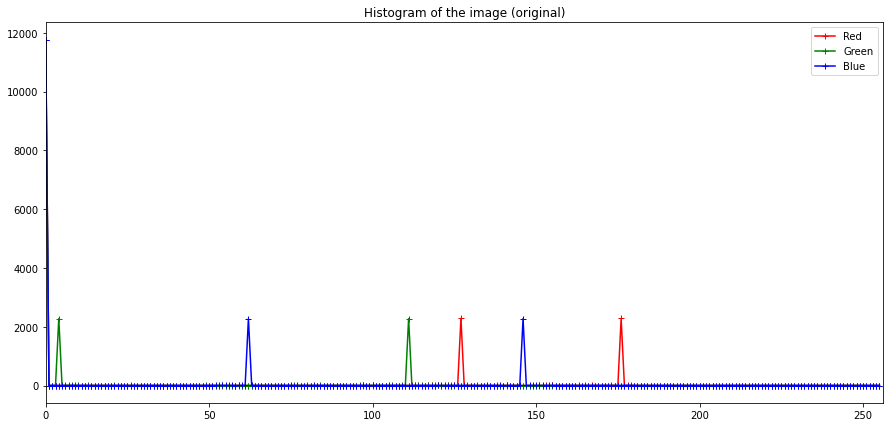

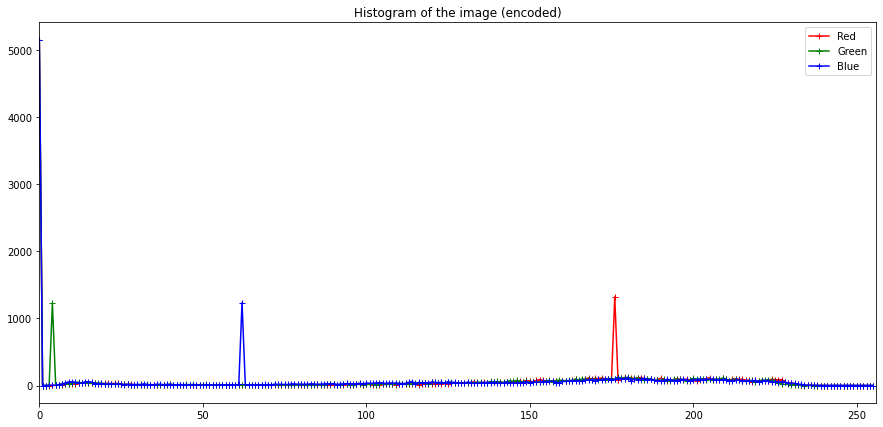

In [74]:
from src.analysis.histogram import generate_histogram, plot_histogram, compare_histograms, compute_diff_imgs

plt.figure(figsize=(15,7))
plt.title('Histogram of the image (original)')
plot_histogram(generate_histogram(image))
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (encoded)')
plot_histogram(generate_histogram(encoded_image))

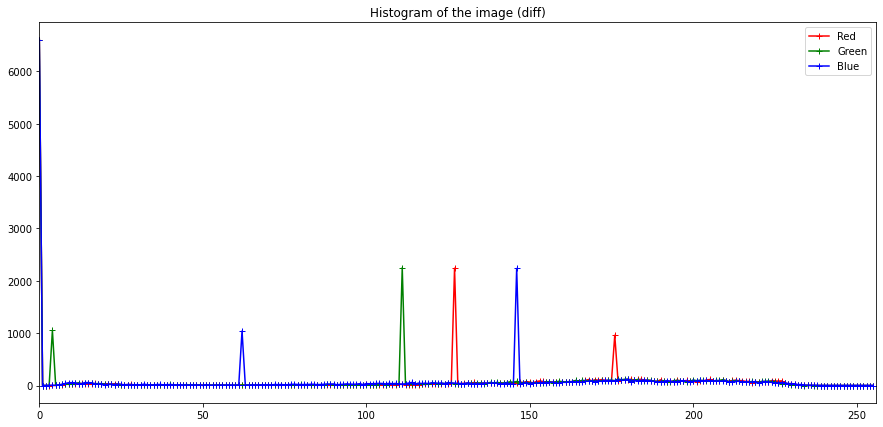

In [75]:
plt.figure(figsize=(15,7))
plt.title('Histogram of the image (diff)')

plot_histogram(
    compare_histograms(
        generate_histogram(image),
        generate_histogram(encoded_image)
    )
)

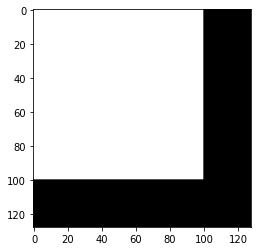

In [76]:
plt.imshow(compute_diff_imgs(image, encoded_image), cmap='gray');